# TP – Prédire le taux d’utilisation CPU d’un serveur à partir d’indicateurs réseau

Dans ce projet, vous allez concevoir, expliquer et évaluer un **modèle de régression** capable d’anticiper la **charge CPU d’un serveur** à partir d’indicateurs réseau, comme on le ferait dans un **Security Operations Center (SOC)** pour **détecter des surcharges** (DDoS) et **comportements anormaux**.


# Hany El Atlassi - CSCC 

## Contexte
Dans un environnement de supervision réseau, plusieurs indicateurs sont collectés à **intervalles réguliers** : le **nombre de connexions TCP actives**, le **volume de données** échangé, le **taux de perte de paquets**, ou encore le **nombre d’alertes** générées par le système de détection d’intrusions (**IDS**).
L’objectif est de construire un modèle de **prédiction de la charge CPU** à partir de ces variables, dans une logique de **prévention proactive** et de **corrélation** entre **activité réseau** et **performance du serveur**.


## Le jeu de données (logs réseau)
Chaque observation correspond à un **intervalle de temps** et contient les variables :

- `tcp_connections` : nombre de connexions TCP actives  
- `data_volume_MB` : volume transmis (Mo)  
- `packet_loss_rate` : taux de perte de paquets (%)  
- `ids_alerts` : nb d’alertes IDS  
- `cpu_load` : charge CPU — *variable cible à prédire*


## Construire un modèle de régression linéaire avancé en suivant les étapes suivantes: 

1. Compréhension du contexte
- Assimiler l’objectif du TP : prédire la charge CPU d’un serveur à partir d’indicateurs réseau dans un contexte SOC.
- Identifier les variables explicatives et la variable cible.

2. Simulation et importation des données
- Charger le jeu de données simulé (soc_cpu_dataset.csv).
- Vérifier la structure et les premières lignes avec df.head().

3. Exploration et pré-traitement
- Aperçu général : statistiques descriptives, types de données.
- Corrélations : analyser la relation entre chaque variable et cpu_load.
- Standardisation : centrer et réduire les variables pour les rendre comparables.

4. Découpage en ensembles
- Réaliser un Train/Test Split (80 % apprentissage, 20 % test).
- Vérifier les dimensions des jeux de données.

5. Sélection de variables
- Utiliser la Sélection Séquentielle de Variables (SequentialFeatureSelector) avec une régression linéaire.
- Identifier les variables les plus pertinentes pour prédire cpu_load.

6. Modélisation et évaluation
- Ajuster un modèle de régression linéaire sur les variables sélectionnées.
- Évaluer le modèle avec les indicateurs :
    - 𝑅2 (qualité d’ajustement),
    - RMSE (erreur moyenne quadratique),
    - Visualisation des prédictions vs valeurs réelles.

7. Amélioration du modèle
- Introduire des termes d’interaction ou polynomiaux (PolynomialFeatures).
- Réentraîner le modèle et comparer les performances (R², RMSE).
- Analyser les résidus pour vérifier la qualité du modèle.

8. Conclusion et recommandations
- Identifier les variables ayant le plus d’impact sur la charge CPU.

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Let's start by reading the dataset and understanding its components

In [48]:
df = pd.read_csv("data/cpu_load_data.csv")
df.head()

,tcp_connections,data_volume_MB,packet_loss_rate,ids_alerts,cpu_load
0,1176,8785.993412,0.167662,7,103.489820
1,1509,7433.609316,2.849448,20,124.307937
2,910,7000.455836,3.812293,17,75.312681
3,1344,7054.592431,4.383828,29,111.447631
4,1180,3658.962397,1.710409,17,58.513370


In [49]:
df.describe()

,tcp_connections,data_volume_MB,packet_loss_rate,ids_alerts,cpu_load
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,1055.626000,5020.209236,2.526169,24.964000,74.092776
std,554.832927,2899.730516,1.474920,14.757041,37.119868
min,51.000000,207.292750,0.023160,0.000000,3.925035
25%,594.500000,2526.350630,1.167228,12.000000,45.454861
50%,1083.000000,5078.990411,2.578816,25.000000,67.256479
75%,1534.250000,7550.991890,3.822507,38.000000,100.025005
max,1995.000000,9997.204966,4.989671,49.000000,179.353562


We notice there are different scales of values in our features, we'll have to standardize the data later on. For now let's start with the basics. We'll check for any null values and deal with them accordingly, and make sure all the data types are correct as well.

In [50]:
print(f"Null values: \n**********************\n{df.isnull().sum()}\n**********************\nFeature Types: \n**********************\n{df.dtypes}")

Null values: 
**********************
tcp_connections     0
data_volume_MB      0
packet_loss_rate    0
ids_alerts          0
cpu_load            0
dtype: int64
**********************
Feature Types: 
**********************
tcp_connections       int64
data_volume_MB      float64
packet_loss_rate    float64
ids_alerts            int64
cpu_load            float64
dtype: object


No null values, the data is clean, let's switch them to floats and move on to standardization

In [51]:
df = df.astype(float)
df.dtypes

tcp_connections     float64
data_volume_MB      float64
packet_loss_rate    float64
ids_alerts          float64
cpu_load            float64
dtype: object

We'll use the classic z-score standardization algorithm to keep the deviation of the dataset.

In [52]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

In [53]:
df.describe()

,tcp_connections,data_volume_MB,packet_loss_rate,ids_alerts,cpu_load
count,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02
mean,3.552714e-17,1.634248e-16,-2.913225e-16,8.526513e-17,1.669775e-16
std,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00
min,-1.812495e+00,-1.661443e+00,-1.698747e+00,-1.693361e+00,-1.892195e+00
25%,-8.319402e-01,-8.608925e-01,-9.222885e-01,-8.793757e-01,-7.722710e-01
50%,4.938679e-02,2.029156e-02,3.573099e-02,2.441957e-03,-1.843526e-01
75%,8.635092e-01,8.736389e-01,8.798015e-01,8.842597e-01,6.993075e-01
max,1.694771e+00,1.718084e+00,1.671934e+00,1.630413e+00,2.838539e+00


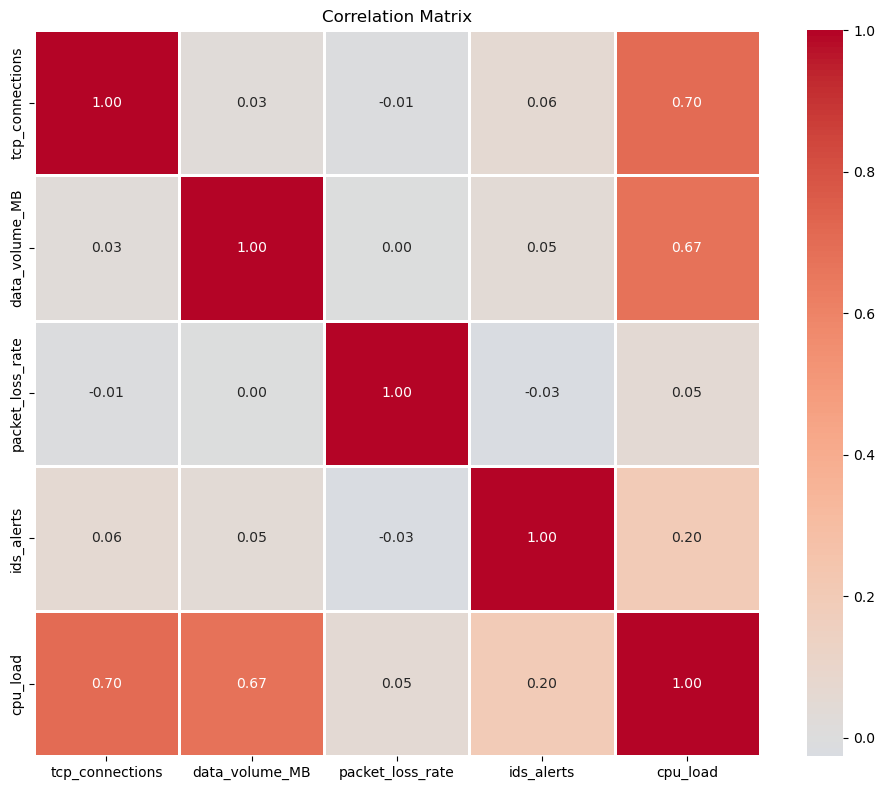

In [54]:
correlation_matrix = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=1,
            fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

The features have practically no dependence on each other, PCA is not needed, we also see direct impact on cpu load from tcp_connections and data_volume_MB, which makes regression more promising. The data is clean and ready to move in the pipeline.

We'll move now to setting up the model, train and test sets, then train and test its precision.

In [55]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [56]:
X = df.drop('cpu_load', axis=1)
y = df['cpu_load']

# I decided to use 10% for the testing set since we need a little more for training, 500 values is too little
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=15)

### Sequential Feature Selection

In [57]:
lr_model = LinearRegression()
sfs = SequentialFeatureSelector(
    lr_model, 
    n_features_to_select='auto',  
    direction='forward',
    cv=5,
    scoring='r2'
)

sfs.fit(X_train, y_train)
selected_features = X_train.columns[sfs.get_support()].tolist()
print(f"\nSelected features: {selected_features}")
print(f"Number of features selected: {len(selected_features)}")

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]


Selected features: ['tcp_connections', 'data_volume_MB']
Number of features selected: 2


### Baseline Model Evaluation

In [58]:
model_baseline = LinearRegression()
model_baseline.fit(X_train_selected, y_train)
y_pred = model_baseline.predict(X_test_selected)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nR² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

# Feature coefficients
print("\nFeature Coefficients:")
for feature, coef in zip(selected_features, model_baseline.coef_):
    print(f"  {feature:20s}: {coef:8.4f}")


R² Score: 0.9188
RMSE: 0.3186

Feature Coefficients:
  tcp_connections     :   0.6779
  data_volume_MB      :   0.6465


### Visualisation

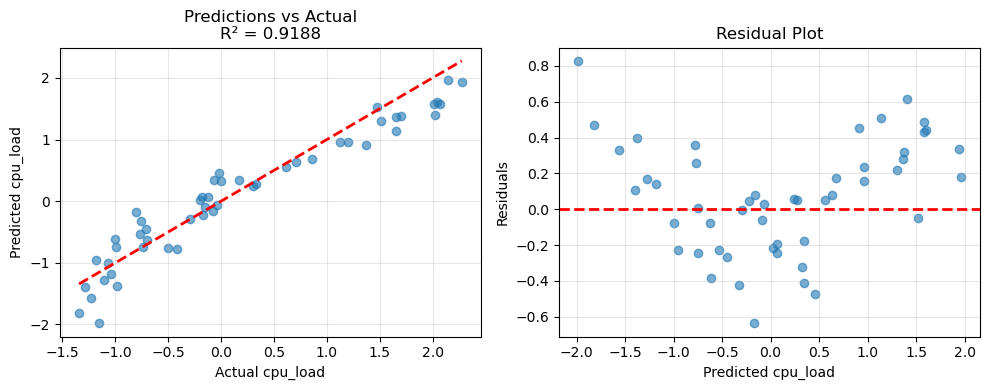

In [59]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual cpu_load')
plt.ylabel('Predicted cpu_load')
plt.title(f'Predictions vs Actual\nR² = {r2:.4f}')
plt.grid(True, alpha=0.3)

# Residuals
residuals = y_test - y_pred
plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted cpu_load')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Model Improvement with Polynomial features

In [60]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_selected)
X_test_poly = poly.transform(X_test_selected)

print(f"\nOriginal features: {X_train_selected.shape[1]}")
print(f"Polynomial features: {X_train_poly.shape[1]}")
print(f"(includes interactions and squared terms)")


model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)
y_pred_poly = model_poly.predict(X_test_poly)

r2_poly = r2_score(y_test, y_pred_poly)
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))

print(f"\nPolynomial Model Performance:")
print(f"R² Score: {r2_poly:.4f} (Δ = {r2_poly - r2:+.4f})")
print(f"RMSE: {rmse_poly:.4f} (Δ = {rmse_poly - rmse:+.4f})")



Original features: 2
Polynomial features: 5
(includes interactions and squared terms)

Polynomial Model Performance:
R² Score: 0.9696 (Δ = +0.0509)
RMSE: 0.1948 (Δ = -0.1238)


### Visualization

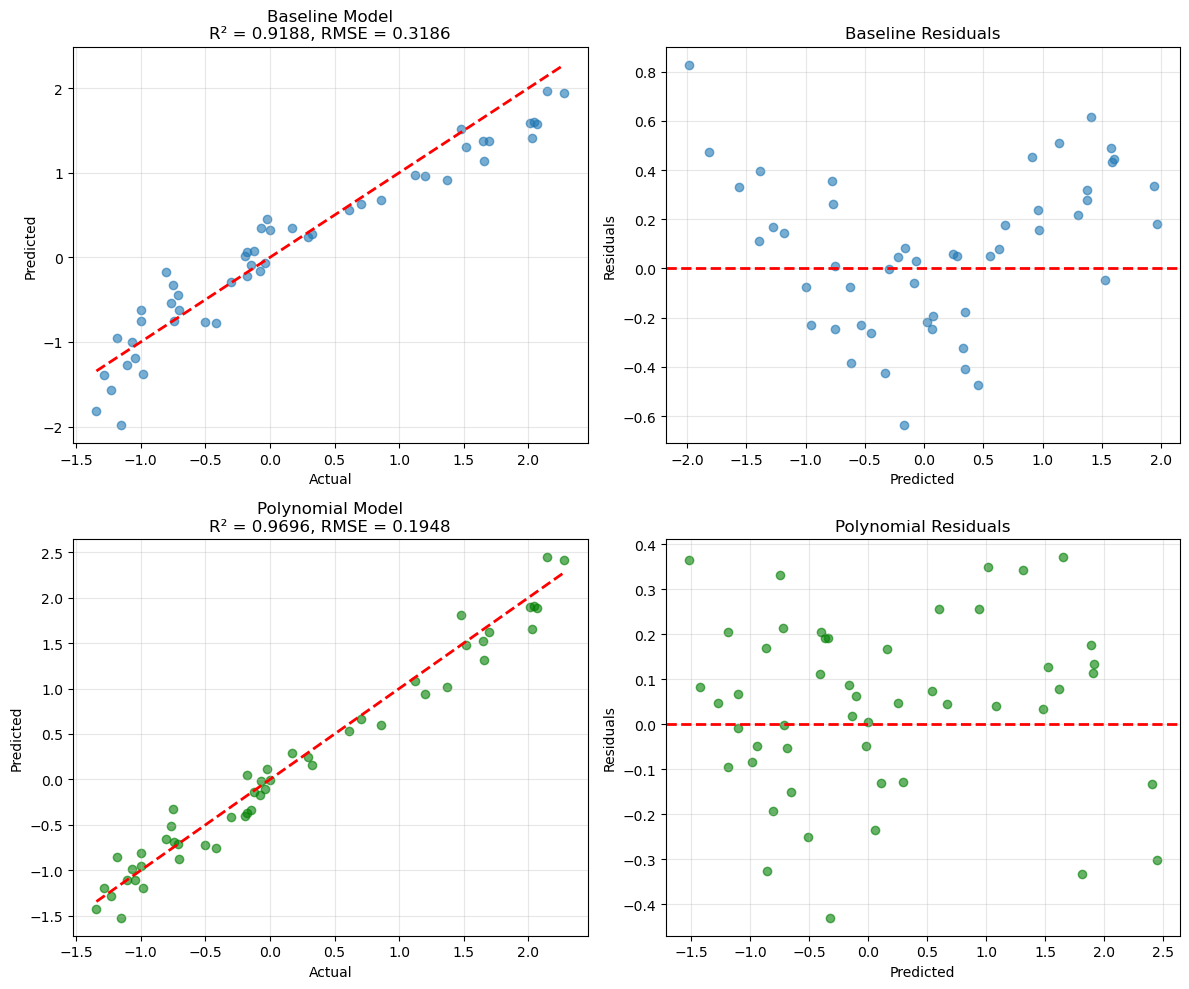

In [61]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Baseline
axes[0, 0].scatter(y_test, y_pred, alpha=0.6)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual')
axes[0, 0].set_ylabel('Predicted')
axes[0, 0].set_title(f'Baseline Model\nR² = {r2:.4f}, RMSE = {rmse:.4f}')
axes[0, 0].grid(True, alpha=0.3)

residuals_base = y_test - y_pred
axes[0, 1].scatter(y_pred, residuals_base, alpha=0.6)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Baseline Residuals')
axes[0, 1].grid(True, alpha=0.3)


# Polynomial
axes[1, 0].scatter(y_test, y_pred_poly, alpha=0.6, color='green')
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('Actual')
axes[1, 0].set_ylabel('Predicted')
axes[1, 0].set_title(f'Polynomial Model\nR² = {r2_poly:.4f}, RMSE = {rmse_poly:.4f}')
axes[1, 0].grid(True, alpha=0.3)

residuals_poly = y_test - y_pred_poly
axes[1, 1].scatter(y_pred_poly, residuals_poly, alpha=0.6, color='green')
axes[1, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].set_title('Polynomial Residuals')
axes[1, 1].grid(True, alpha=0.3)


plt.tight_layout()
plt.show()



RESIDUAL ANALYSIS

Baseline Model:
  Mean residual: 0.0725
  Std residual: 0.3134

Polynomial Model:
  Mean residual: 0.0406
  Std residual: 0.1924


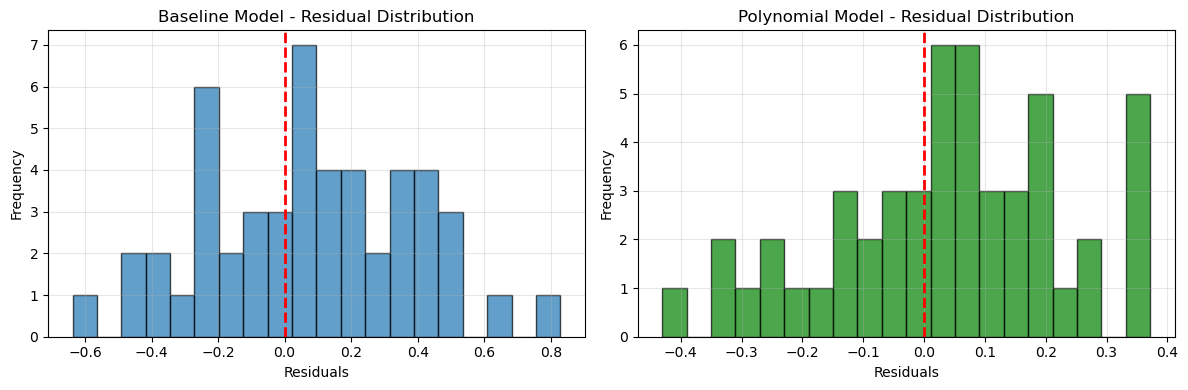

In [ ]:
# Residual distribution analysis
print("\n" + "=" * 50)
print("RESIDUAL ANALYSIS")
print("=" * 50)

print("\nBaseline Model:")
print(f"  Mean residual: {residuals_base.mean():.4f}")
print(f"  Std residual: {residuals_base.std():.4f}")

print("\nPolynomial Model:")
print(f"  Mean residual: {residuals_poly.mean():.4f}")
print(f"  Std residual: {residuals_poly.std():.4f}")

# Residual distribution plots
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(residuals_base, bins=20, alpha=0.7, edgecolor='black')
plt.axvline(x=0, color='r', linestyle='--', lw=2)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Baseline Model - Residual Distribution')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(residuals_poly, bins=20, alpha=0.7, color='green', edgecolor='black')
plt.axvline(x=0, color='r', linestyle='--', lw=2)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Polynomial Model - Residual Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Conclusion Finale

Le modèle de regression linéaire est parfait pour ce type de problème, mais cela n'empêche pas d'optimiser la structure des features pour mieux représenter l'état des données au modèle. Grace au modèle polynomial, on a pu augmenter notre précision, sans changer la quantité des données.

Les variables ayant le plus d'impact sur la charge du CPU restent "tcp_connections" et "data_volume_MB". 